# Single-node training example

In [1]:
# Pick up the local code
import sys
sys.path.append('..')

In [2]:
# Externals
import keras
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

# Locals
from data import get_datasets
from models import get_model
from utils.device import configure_session
from utils.optimizers import get_optimizer
from utils.callbacks import TimingCallback

Using TensorFlow backend.


In [3]:
%matplotlib inline

## Introduction

We will be doing image classification on CIFAR10:
https://www.cs.toronto.edu/~kriz/cifar.html

We will be training a simple CNN model to classify small images into 10 classes.

Let's start by looking at some example images from the dataset.

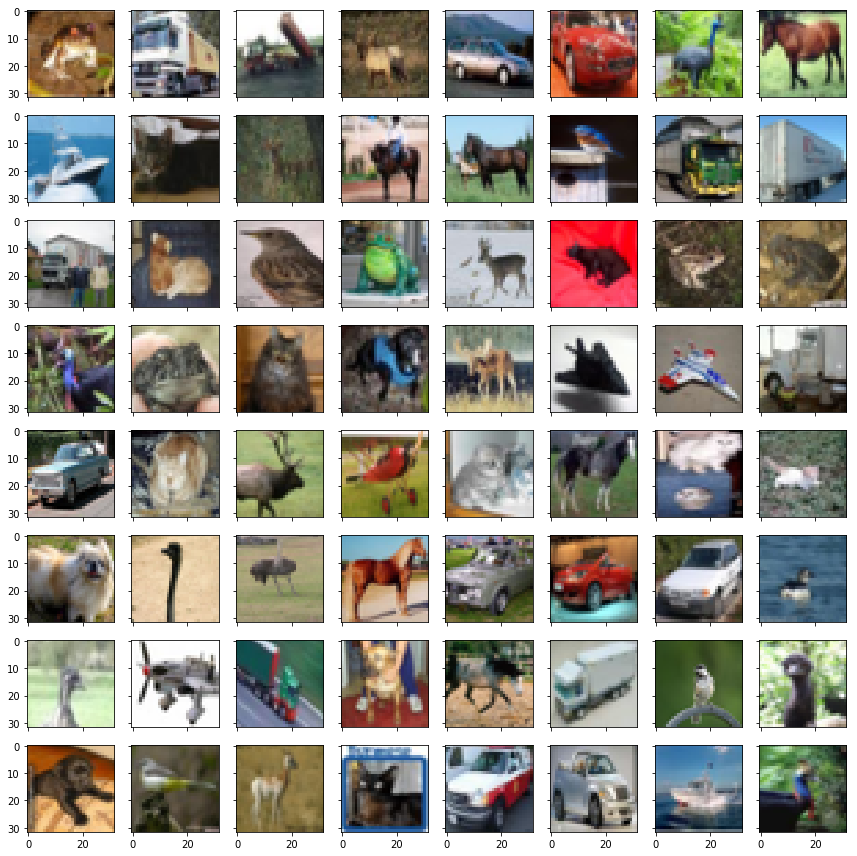

In [4]:
x, y = cifar10.load_data()[0]

nrows = 8
ncols = 8

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharex=True, sharey=True)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(x[i])
    
plt.tight_layout()

## Configuration

Here is where we will specify all of our configuration of the model, optimizer, and training procedure.

I'll also set some hardware related settings.

In [5]:
# Model config
model_name = 'cnn'
input_shape = [32, 32, 3]
n_classes = 10
dropout = 0.1

# Optimizer config
optimizer_name = 'Adam'
lr = 0.001

# Training config
batch_size = 32
n_epochs = 32
loss_name = 'categorical_crossentropy'
metrics = ['accuracy']

In [6]:
# Identify which gpu is free for us to use
!gpustat

maeve  Wed Jan 16 00:54:04 2019
[0] TITAN X (Pascal) | 39'C,   0 % |     0 / 12194 MB |
[1] TITAN X (Pascal) | 27'C,   0 % |     0 / 12196 MB |
[2] TITAN X (Pascal) | 25'C,   3 % |     0 / 12196 MB |


In [7]:
# Hardware config
gpu = 0
intra_threads = 2 # CPU performance knob
inter_threads = 2 # CPU performance knob

In [8]:
configure_session(gpu=gpu, intra_threads=intra_threads, inter_threads=inter_threads)

In [9]:
# Now we should see some memory allocated on our requested GPU
!gpustat

maeve  Wed Jan 16 00:54:05 2019
[0] TITAN X (Pascal) | 40'C,   8 % |   221 / 12194 MB | sfarrell(211M)
[1] TITAN X (Pascal) | 28'C,   0 % |    10 / 12196 MB |
[2] TITAN X (Pascal) | 26'C,   0 % |    10 / 12196 MB |


## Load the data

Here we use the local get_datasets code to retrieve and configure our data.

This actually returns data generator iterators which can read data and perform on-the-fly augmentation.

In [10]:
# Load the data
train_gen, valid_gen = get_datasets(name='cifar10', batch_size=batch_size)

## Build the model

Now we use our local get_model code to build our CNN model according to our configuration.

In [11]:
# Build the model and optimizer
model = get_model(name=model_name, input_shape=input_shape, n_classes=n_classes, dropout=dropout)
opt = get_optimizer(name=optimizer_name, lr=lr)
model.compile(loss=loss_name, optimizer=opt, metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

## Train the model

We use the fit_generator method to train our CNN model on our data generators.

Watch the progess as our model eats through the training data and regularly evaluates on the validation data.

In [12]:
# Train the model
history = model.fit_generator(train_gen,
                              epochs=n_epochs,
                              steps_per_epoch=len(train_gen),
                              validation_data=valid_gen,
                              validation_steps=len(valid_gen))

Epoch 1/32
1563/1563 [==============================] - 17s 11ms/step - loss: 1.6030 - acc: 0.4143 - val_loss: 1.2910 - val_acc: 0.5322
Epoch 2/32
1563/1563 [==============================] - 15s 10ms/step - loss: 1.2987 - acc: 0.5343 - val_loss: 1.1441 - val_acc: 0.5985
Epoch 3/32
1563/1563 [==============================] - 15s 10ms/step - loss: 1.1695 - acc: 0.5819 - val_loss: 1.0260 - val_acc: 0.6325
Epoch 4/32
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0821 - acc: 0.6156 - val_loss: 0.9853 - val_acc: 0.6517
Epoch 5/32
1563/1563 [==============================] - 15s 9ms/step - loss: 1.0180 - acc: 0.6389 - val_loss: 0.9022 - val_acc: 0.6814
Epoch 6/32
1563/1563 [==============================] - 15s 9ms/step - loss: 0.9768 - acc: 0.6535 - val_loss: 0.8916 - val_acc: 0.6918
Epoch 7/32
1563/1563 [==============================] - 15s 10ms/step - loss: 0.9306 - acc: 0.6708 - val_loss: 0.8716 - val_acc: 0.7007
Epoch 8/32
1563/1563 [============================

## Visualize training history

Training has now completed. We can use the returned history object to make plots of the training and validation set losses and accuracies during training. This is very valuable for identifying issues like under/over fitting!

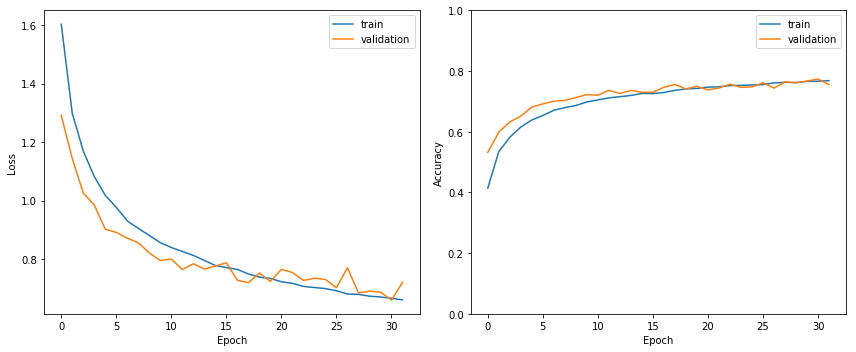

In [13]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

# Plot the loss
ax0.plot(history.epoch, history.history['loss'], label='train')
ax0.plot(history.epoch, history.history['val_loss'], label='validation')
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

# Plot the accuracy
ax1.plot(history.epoch, history.history['acc'], label='train')
ax1.plot(history.epoch, history.history['val_acc'], label='validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(bottom=0, top=1)
ax1.legend(loc=0)


plt.tight_layout()

## What to try next?

Now that you've gotten this far, familiarize yourself with what you can change in the configuration and the effect it has on model performance.

For example:
- What happens if you increase or decrease the learning rate by a factor of 10?
- What happens if you greatly increase or decrease the size of the model in number and size of layers?